In [1]:
import json
import itertools
from basics import *
from plotting import *
from matplotlib import cm
from ase import Atoms

plt.style.use("paper")

## Visualizing the Monte Carlo approach

In [2]:
facets = [100, 111, 211, 331, 410, 711]
nads = np.arange(2, 19)

In [4]:
df = pd.read_csv("../data/mcmc/energies.csv.gz", compression="gzip", index_col=0)

In [5]:
len(df)

14322349

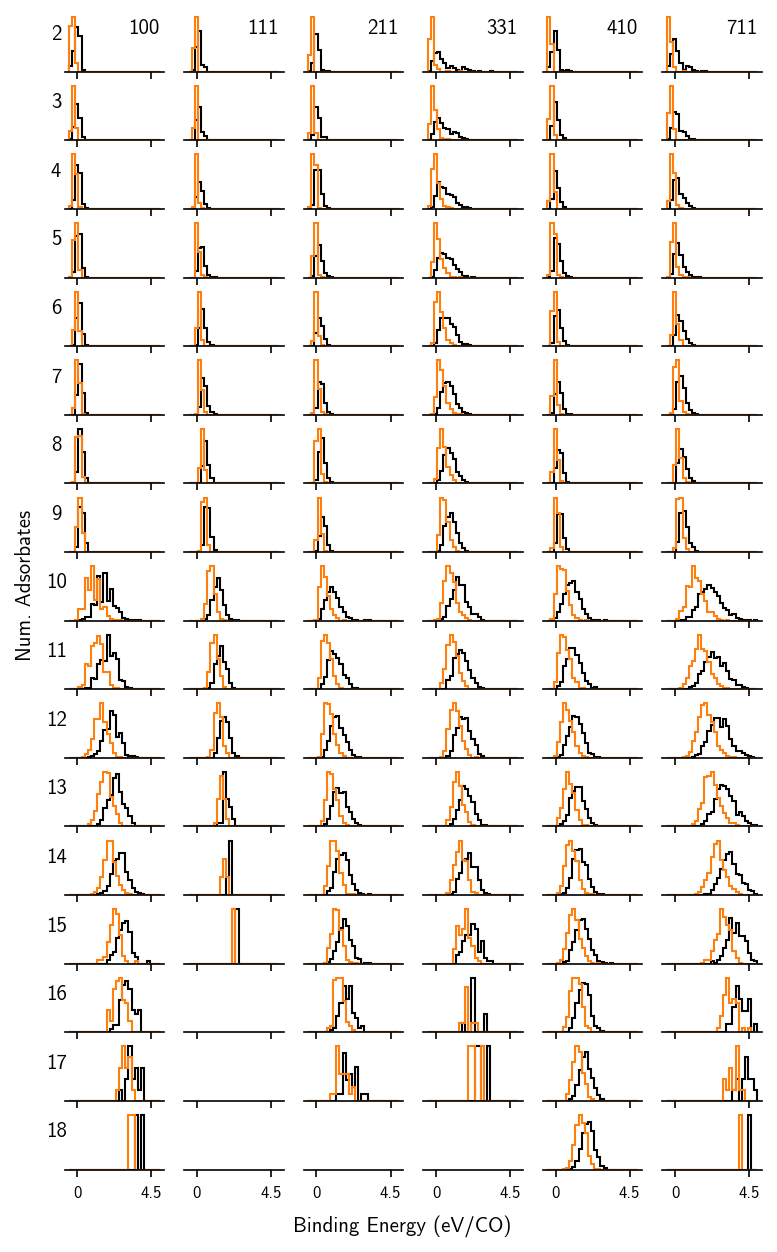

In [5]:
fig, axs = plt.subplots(17, 6, figsize=(6, 10), sharex=True)

bins = np.linspace(-0.5, 5.0, 30)

for (facet, n), grp in df.groupby(["facet", "n"]):
    i, j = n - 2, facets.index(facet)
    ax = axs[i, j]
    
    en = grp.pivot(index="move", columns="replica", values="energy")
    en = en / n
    
    ax.hist(en.iloc[0], bins=bins, color="k", histtype="step")
    ax.hist(en.min(0), bins=bins, color=cm.tab10(1), histtype="step")
    
    if i == 0:
        ax.annotate(facet, (0.95, 0.95), xycoords="axes fraction", ha="right", va="top")

for ax in axs.reshape(-1):
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for ax in axs[-1, :]:
    ticks = [0, 4.5]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, fontsize=8)
#     ax.set_xlabel("E$_b$ (eV/CO)", fontsize=10)
    
for i, ax in enumerate(axs[:, 0], 2):
    ax.set_ylabel(i, rotation=0)

fig.supxlabel("Binding Energy (eV/CO)", y=0.065, fontsize=10)
fig.supylabel("Num. Adsorbates", x=0.07, fontsize=10)

savefig(fig, "04-sampling-distributions.pdf")
plt.show()

In [13]:
df

,move,replica,energy,facet,n
0,0,0,-0.026355,100,2
1,0,1,-0.354427,100,2
2,0,2,-0.094362,100,2
3,0,3,0.150745,100,2
4,0,4,-0.119381,100,2
...,...,...,...,...,...
176,176,0,72.814459,711,18
177,177,0,72.814459,711,18
178,178,0,72.814459,711,18
179,179,0,72.814459,711,18


## Visualizing the sampling curves

In [6]:
facet, n = 410, 10

with open(f"../data/mcmc/configs/{facet}-{n:02d}.json", "r") as f:
    temps = json.load(f)["temperature"]

In [7]:
grp = df.loc[(df["facet"] == facet) & (df["n"] == n)]
en = grp.pivot(index="move", columns="replica", values="energy")
en = en / n

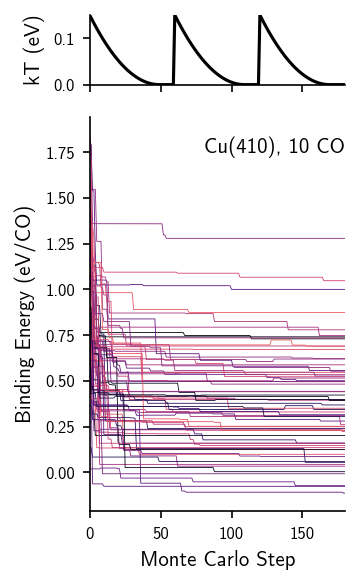

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(2.5, 4), sharex=True, height_ratios=[0.15, 0.85])

norm = plt.Normalize(0, 1.5)
cmap = lambda x: cm.magma(norm(x))

def random_color():
    return cmap(np.random.uniform())

ax = axs[0]
ax.plot(temps, "k-")
ax.set_ylim(0, 0.15)
ax.set_ylabel("kT (eV)")

ax = axs[1]
for i, row in en.T.iterrows():
    if i % 15 != 0:
        continue
    ax.plot(row.values, color=random_color(), linewidth=0.4)

ax.annotate(f"Cu({facet}), {n:02d} CO", (1.0, 0.95), xycoords="axes fraction", ha="right", va="top")
ax.set_ylabel("Binding Energy (eV/CO)")
ax.set_xlabel("Monte Carlo Step")
ax.set_xlim(0, 180)

fig.tight_layout()
savefig(fig, "04-sampling-profile.pdf")
plt.show()

## Comparing the initial and sampled distributions

In [16]:
sampled = pd.read_json("../data/mcmc/mcmc_results.json")
original = pd.read_json("../data/231003-COv-data.json")

In [21]:
original["unrelax_binding_site"].min()

-0.59608817

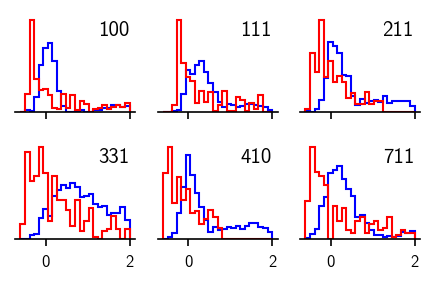

In [33]:
bins = np.linspace(-0.6, 2.0, 25)

hist_kwargs = {
    "histtype": "step",
    "density": True,
    "bins": bins,
}

fig, axs = plt.subplots(2, 3, figsize=(3, 2), sharex=True)

for ax, facet in zip(axs.ravel(), [100, 111, 211, 331, 410, 711]):
    orig = original.loc[original["facet"] == facet]
    samp = sampled.loc[sampled["facet"] == facet]
    
    ax.hist(orig["unrelax_binding_site"], color="b", **hist_kwargs)
    ax.hist(samp["binding_unrelax_site"], color="r", **hist_kwargs)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.annotate(facet, (0.95, 0.95), xycoords="axes fraction", ha='right', va="top")

fig.tight_layout()
savefig(fig, "04-sampling-comparison.pdf")
plt.show()